# Desafio P&D (Machine Learning) Intelivix

Em processamento e entendimento de linguagem natural, a análise de sentimento é uma das áreas que mais têm recebido atenção da comunidade científica. Os seus desafios encontram-se principalmente na identificação e tratamento adequado de sarcasmo, ambiguidade linguística, negação, etc. Este desafio consiste em classificar os trechos de textos opinativos sobre filmes presentes na base fornecida em 5 níveis de sentimento: negativo, um pouco negativo, neutro, um pouco positivo e positivo.

Sobre a entrega:

* Deve-se escolher 3 diferentes algoritmos de classificação ou regressão. Deve-se utilizar apenas o arquivo train.tsv para criar as bases de treino, validação e teste, comparando os algoritmos com a base de teste e escolhendo o melhor, justificando a escolha.


* Os códigos e o relatório devem ser entregues em um ipython notebook didático, o qual deve ser auto-suficiente para ser executado (assumindo que o computador a executar possua todas as ferramentas necessárias instaladas).


* O relatório deve conter todas as tentativas para resolver o problema, como se estivesse contando a história da estrada percorrida para se chegar no resultado.


## Bibliotecas Utilizadas:




Para a resolução deste trabalho foram utilizada as bibliotecas Pandas, para a leitura e organização dos dados.

Na etapa de exploração dos mesmos foi utilizado a matplotlib, seaborn e wordcloud possibilitando a geração de gráficos e nuvens de palavras. 

Na parte de préprocessameto foi importada a biblioteca nltk que possibilitou a extração de stopwords e de stemming das palavras. 

Para a criação de modelos, vetorização dos termos e validação dos mesmos empregado a biblioteca sklearn, importando para a vetorização a CountVectorizer; criação dos modelos MultinomialNB (Naive Bayes), LinearSVC (Linear Support Vector Classification) e DecisionTreeClassifier (Árvore de Decisão); e para suas validações a biblioteca cross_val_predict e metrics 

### Importando bibliotecas


In [37]:
#import libs
import pandas as pd 
#data exploration and analisys
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
#preprocessing
import nltk 
from nltk.corpus import stopwords 
#vectorizer
from sklearn.feature_extraction.text import CountVectorizer
#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
#validation
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

### Abrindo base de dados

In [2]:
#open de dataset 
reviews = pd.read_csv("train.tsv", sep="\t")
reviews.head(10)

,Id,IdSentenca,Texto,Sentimento
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [3]:
# clear reviews dataset
reviews.drop_duplicates(inplace=True)
reviews.dropna(inplace=True)
reviews['Id'] -=1
reviews.set_index('Id',inplace=True)

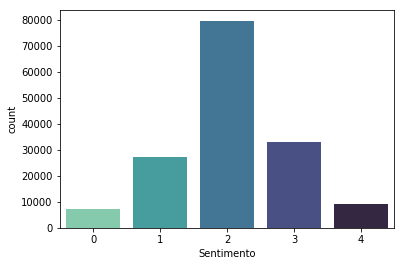

In [4]:
sns.countplot(x='Sentimento', data=reviews, palette='mako_r')
plt.show()

## Pré-Processamento dos Dados

Como podemos visualizar na base de dados, para um mesmo comentário possuimos varias linhas de dados que compõe o mesmo e cada uma dessas frases possui um valor de sentimento atribuido podendo ser diferente ou não do comentário original. Visto isto para testar uma hipótese iremos fazer a utilização desta base de dados de duas maneiras, a primeira com o dataset original, ou seja, com os comentarios e suas frases que o compõe e na segunda limparemos a base de dados deixando somente os comentários originais, com isso será possivel dizer no final se essas frases em pedaçõs e com valores de sentimentos diferentes atribuidos podem vim a interferir na classificação final de um review.

A primeira base de dados chamaremos de "reviews", como já foi atribuida no começo, quando aberto o dataset, e a segunda será chamada de "reviewsComments". E para fins de curiosidade, também iremos testar o modelo de duas formas, com os comentarios como estão na base de dados e depois de processa-los, cujo está descrito abaixo como prosseguiremos nesta etapa.

Nesta fase de préprocessamento dos dados, será realizado duas etapas, sendo a primeira a de Leitura dos Dados, para definir como os dados serão lidos, aqui organizaremos suas colunas e seus valores, também feito a remoção de dados duplicados ou com valores nulos caso a base de dados apresentem tais valores.

Após termos concluido a fase de Leitura dos dados, antes de passarmos para a segunda etapa do préprocessamento, será feita uma exploração dos dados para verificarmos quais são os sentimentos que mais aparecem no dataset, assim como uma contagem dos termos e suas frequencias nos comentários.

Em seguida, na segunda etapa do préprocessamento será feita a Limpeza e Extração dos termos, está será divida em três sub etapas, sendo elas:

* Remoção de caracteres especiais;


* Remoção das Stop Words de cada comentario;


* E por ultimo o Stemming, para redução das palavras em seus radicais 


### Leitura dos Dados

In [5]:
# Make a new dataset with only the original comments
reviewsComments = reviews.copy()  
# Remove duplicate values in Id Sentenca
reviewsComments.drop_duplicates('IdSentenca', inplace=True)
# Start IdSentenca in 0
reviewsComments['IdSentenca'] -= 1
# Remove values NaN
reviewsComments.dropna(inplace=True)
# Remove Id Column


In [6]:
# Set index with IdSetenca values and drop col Id
reviewsComments.set_index('IdSentenca', inplace=True)

In [7]:
reviewsComments.head(10)

,Texto,Sentimento
IdSentenca,,
0,A series of escapades demonstrating the adage ...,1
1,"This quiet , introspective and entertaining in...",4
2,"Even fans of Ismail Merchant 's work , I suspe...",1
3,A positively thrilling combination of ethnogra...,3
4,Aggressive self-glorification and a manipulati...,1
5,A comedy-drama of nearly epic proportions root...,4
6,"Narratively , Trouble Every Day is a plodding ...",1
7,"The Importance of Being Earnest , so thick wit...",3
8,But it does n't leave you with much .,1


### Limpeza e extração dos termos 

In [8]:
# remove stop words and punctuation of a comment
def Process_Comment(sentence):
    sentence = sentence.replace(',','').replace('.','').replace('!','').replace('?','').replace(':','').replace(';','')
    stopwords = nltk.corpus.stopwords.words('english')
    stemmer = nltk.stem.RSLPStemmer()
    comment = []
    for i in sentence.split():
        if i not in stopwords:
            comment.append(stemmer.stem(i))
    return (" ".join(comment))

In [9]:
reviewsComments['TextoProcessado'] = [Process_Comment(i) for i in reviewsComments['Texto']]

In [10]:
reviews['TextoProcessado'] = [Process_Comment(i) for i in reviews['Texto']]

In [11]:
reviewsComments.head()

,Texto,Sentimento,TextoProcessado
IdSentenca,,,
0,A series of escapades demonstrating the adage ...,1,a seri escapad demonstrating adag good goos al...
1,"This quiet , introspective and entertaining in...",4,thil quiet introspectiv entertaining independe...
2,"Even fans of Ismail Merchant 's work , I suspe...",1,even fam ismail merchant 's work i suspect wou...
3,A positively thrilling combination of ethnogra...,3,a positively thrilling combination ethnography...
4,Aggressive self-glorification and a manipulati...,1,aggressiv self-glorification manipulativ white...


In [12]:
reviews.head()

,IdSentenca,Texto,Sentimento,TextoProcessado
Id,,,,
0,1,A series of escapades demonstrating the adage ...,1,a seri escapad demonstrating adag good goos al...
1,1,A series of escapades demonstrating the adage ...,2,a seri escapad demonstrating adag good goos
2,1,A series,2,a seri
3,1,A,2,a
4,1,series,2,seri


## Exploração dos dados

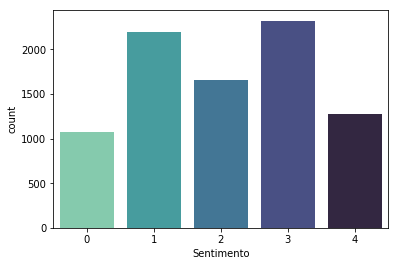

In [13]:
#plotagem dos sentimentos nas base de dados
sns.countplot(x='Sentimento', data=reviewsComments, palette='mako_r')
plt.show()

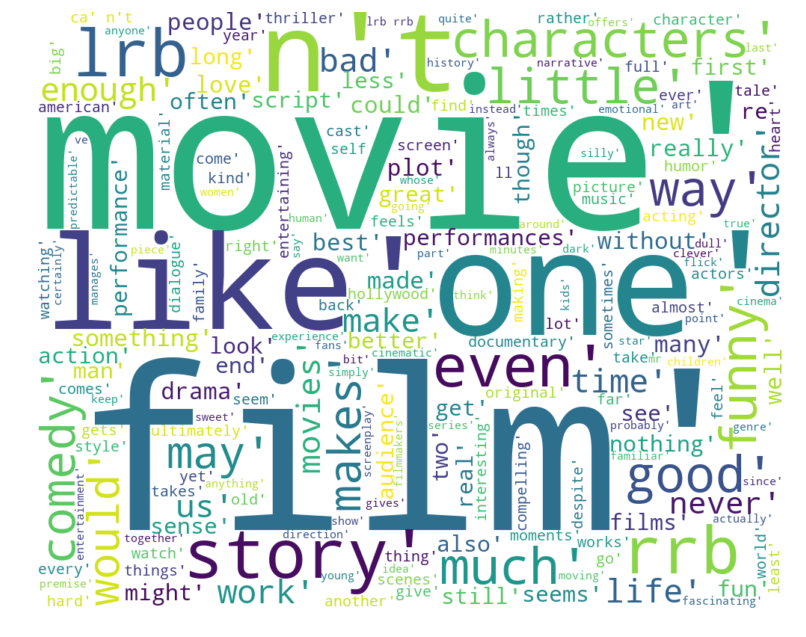

In [83]:
stopWords = nltk.corpus.stopwords.words('english')
word = []
for i in reviewsComments.Texto:
    for p in i.lower().split():
        if p not in stopWords:
            word.append(p)
word = str(word)

wordcloud = WordCloud(width=1000, height=800, margin=0, background_color='white').generate(word)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0,y=0)

In [100]:
stopWords = nltk.corpus.stopwords.words('english')
word = []
reviewsCommentsPositive = reviewsComments[(reviewsComments['Sentimento'] == 0)|(reviewsComments['Sentimento'] == 1)]

for i in reviewsCommentsPositive['Texto']:
    for p in i.lower().split():
        if p not in stopWords:
            word.append(p)
word = str(word)

wordcloud = WordCloud(width=1000, height=800, margin=0, background_color='white').generate(word)
plt.figure(figsize=(20,11))
plt.title("Palavras Comuns em Comentarios neutros")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0,y=0)

Error in callback <function post_execute at 0x7f33914f7668> (for post_execute):


ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

ValueError: matplotlib display text must have all code points < 128 or use Unicode strings

<Figure size 1440x792 with 1 Axes>

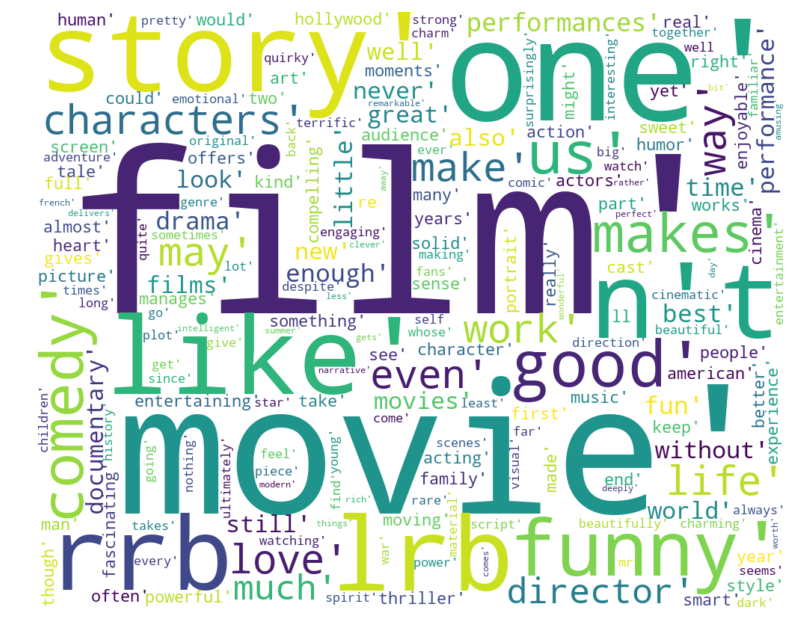

In [95]:
stopWords = nltk.corpus.stopwords.words('english')
word = []
reviewsCommentsPositive = reviewsComments[(reviewsComments['Sentimento'] == 4)|(reviewsComments['Sentimento'] == 3)]

for i in reviewsCommentsPositive['Texto']:
    for p in i.lower().split():
        if p not in stopWords:
            word.append(p)
word = str(word)

wordcloud = WordCloud(width=1000, height=800, margin=0, background_color='white').generate(word)
plt.figure(figsize=(20,11))
plt.title('Palavras mais frequentes nos comentarios positivos',)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0,y=0)

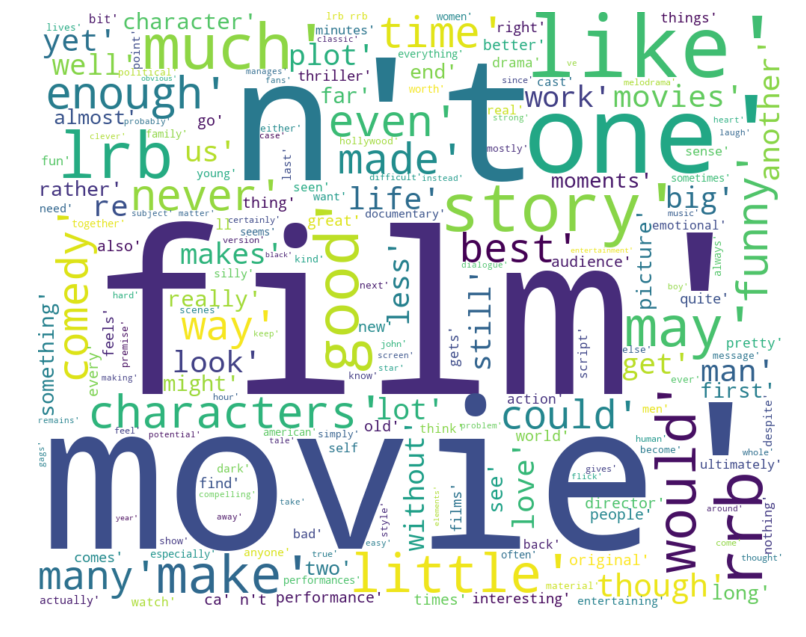

In [94]:
stopWords = nltk.corpus.stopwords.words('english')
word = []
reviewsCommentsPositive = reviewsComments[(reviewsComments['Sentimento'] == 2)]

for i in reviewsCommentsPositive['Texto']:
    for p in i.lower().split():
        if p not in stopWords:
            word.append(p)
word = str(word)

wordcloud = WordCloud(width=1000, height=800, margin=0, background_color='white').generate(word)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0,y=0)

# Modelos

Para tentar solucionar o problema, foi proposto 3 modelos diferentes, sendo aplicados nas duas bases de dados "reviews" e "reviewsComments".

Os modelos utilizados foram:

* Naive Bayes;

* Linear Support Vector Classifier (SVC)

* Decision Tree

In [18]:
vectorizer = CountVectorizer(analyzer="word")
sentimento=[0,1,2,3,4]

In [19]:
#vectorize reviews
vecReviews = vectorizer.fit_transform(reviews.Texto)
vecProcessReviews = vectorizer.fit_transform(reviews.TextoProcessado)

#vectorize comments
vecComments = vectorizer.fit_transform(reviewsComments.Texto)
vecProcessComments = vectorizer.fit_transform(reviewsComments.TextoProcessado)

### Naive Bayes

In [20]:
#create models
modelNBReviews = MultinomialNB()
modelNBReviewsP = MultinomialNB()

modelNBComments = MultinomialNB()
modelNBCommentsP = MultinomialNB()

#train models
modelNBReviews.fit(vecReviews, reviews.Sentimento)
modelNBReviewsP.fit(vecProcessReviews, reviews.Sentimento)

modelNBComments.fit(vecComments, reviewsComments.Sentimento)
modelNBCommentsP.fit(vecProcessComments, reviewsComments.Sentimento)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Validando modelo Naive Bayes

* Validação cruzada

In [21]:
resultsNBReviews = cross_val_predict(modelNBReviews, vecReviews, reviews.Sentimento, cv=10)
resultsNBReviewsP = cross_val_predict(modelNBReviewsP, vecProcessReviews, reviews.Sentimento, cv=10)

resultsNBComments = cross_val_predict(modelNBComments, vecComments, reviewsComments.Sentimento, cv=10)
resultsNBCommentsP = cross_val_predict(modelNBCommentsP, vecProcessComments, reviewsComments.Sentimento, cv=10)

* Accuracy

In [22]:
print('Accuracy Naive Bayes da base de dados Completa sem o texto processado: ', metrics.accuracy_score(reviews.Sentimento, resultsNBReviews))
print('Accuracy Naive Bayes da base de dados Completa com o texto processado: ', metrics.accuracy_score(reviews.Sentimento, resultsNBReviewsP))

print('Accuracy Naive Bayes da base de dados so com Comentarios sem o texto processado: ', metrics.accuracy_score(reviewsComments.Sentimento, resultsNBComments))
print('Accuracy Naive Bayes da base de dados so com Comentarios sem o texto processado: ', metrics.accuracy_score(reviewsComments.Sentimento, resultsNBCommentsP))

('Accuracy Naive Bayes da base de dados Completa sem o texto processado: ', 0.5199666794822504)
('Accuracy Naive Bayes da base de dados Completa com o texto processado: ', 0.526002819428425)
('Accuracy Naive Bayes da base de dados so com Comentarios sem o texto processado: ', 0.392191347168484)
('Accuracy Naive Bayes da base de dados so com Comentarios sem o texto processado: ', 0.38339781920506505)


* Métricas de validação

In [23]:
print(metrics.classification_report(reviews.Sentimento, resultsNBReviews, sentimento))
print(metrics.classification_report(reviews.Sentimento, resultsNBReviewsP, sentimento))

print(metrics.classification_report(reviewsComments.Sentimento, resultsNBComments, sentimento))
print(metrics.classification_report(reviewsComments.Sentimento, resultsNBCommentsP, sentimento))

              precision    recall  f1-score   support

           0       0.24      0.21      0.22      7072
           1       0.35      0.31      0.33     27273
           2       0.64      0.69      0.67     79582
           3       0.44      0.41      0.43     32927
           4       0.27      0.26      0.27      9206

   micro avg       0.52      0.52      0.52    156060
   macro avg       0.39      0.38      0.38    156060
weighted avg       0.51      0.52      0.51    156060

              precision    recall  f1-score   support

           0       0.23      0.19      0.21      7072
           1       0.35      0.28      0.31     27273
           2       0.63      0.73      0.67     79582
           3       0.45      0.40      0.42     32927
           4       0.29      0.23      0.26      9206

   micro avg       0.53      0.53      0.53    156060
   macro avg       0.39      0.37      0.37    156060
weighted avg       0.50      0.53      0.51    156060

              precisio

* Matriz de confusão

In [65]:
confMatReviewsNB = confusion_matrix(reviews.Sentimento, resultsNBReviews)
confMatReviewsPNB = confusion_matrix(reviews.Sentimento, resultsNBReviewsP)

confMatCommentsNB = confusion_matrix(reviewsComments.Sentimento, resultsNBComments)
confMatCommentsPNB = confusion_matrix(reviewsComments.Sentimento, resultsNBCommentsP)

print(confMatReviewsNB)
print('\n')
print(confMatReviewsPNB)
print('\n')
print (confMatCommentsNB)
print('\n')
print (confMatCommentsPNB)

[[ 1477  3023  2097   343   132]
 [ 2322  8388 13874  2153   536]
 [ 1816 10030 55272  9882  2582]
 [  403  2249 13422 13595  3258]
 [   63   269  1753  4707  2414]]


[[ 1339  2919  2376   332   106]
 [ 2069  7554 14925  2257   468]
 [ 1959  8894 57746  9169  1814]
 [  370  1902 14543 13328  2784]
 [   64   246  1968  4807  2121]]


[[ 105  702   73  179   13]
 [ 112 1303  227  499   59]
 [  50  681  200  655   69]
 [  21  461  173 1424  242]
 [   6  157   47  758  313]]


[[ 182  605  106  159   20]
 [ 162 1180  279  509   70]
 [  61  641  246  609   98]
 [  39  429  243 1304  306]
 [   9  159   69  686  358]]


### Linear Support Vector Classifier (SVC)

In [25]:
#create models
modelSVC = LinearSVC(dual=False)
modelSVCP = LinearSVC(dual=False)

modelSVCComments = LinearSVC(dual=False)
modelSVCCommentsP = LinearSVC(dual=False)

#train models
modelSVC.fit(vecReviews, reviews.Sentimento)
modelSVCP.fit(vecProcessReviews, reviews.Sentimento)

modelSVCComments.fit(vecComments, reviewsComments.Sentimento)
modelSVCCommentsP.fit(vecProcessComments, reviewsComments.Sentimento)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

#### Validando SVM

* Validação Cruzada

In [26]:
resultsSVC = cross_val_predict(modelSVC, vecReviews, reviews.Sentimento, cv=10)
resultsSVCP = cross_val_predict(modelSVCP, vecProcessReviews, reviews.Sentimento, cv=10)

resultsSVCComments = cross_val_predict(modelSVCComments, vecComments, reviewsComments.Sentimento, cv=10)
resultsSVCCommentsP = cross_val_predict(modelSVCCommentsP, vecProcessComments, reviewsComments.Sentimento, cv=10)

* Accuracy

In [27]:
print('Accuracy LinearSVC da base de dados Completa sem o texto processado: ', metrics.accuracy_score(reviews.Sentimento, resultsSVC))
print('Accuracy LinearSVC da base de dados Completa com o texto processado: ', metrics.accuracy_score(reviews.Sentimento, resultsSVCP))

print('Accuracy LinearSVC da base de dados so com Comentarios sem o texto processado: ', metrics.accuracy_score(reviewsComments.Sentimento, resultsSVCComments))
print('Accuracy LinearSVC da base de dados so com Comentarios sem o texto processado: ', metrics.accuracy_score(reviewsComments.Sentimento, resultsSVCCommentsP))

('Accuracy LinearSVC da base de dados Completa sem o texto processado: ', 0.5479687299756504)
('Accuracy LinearSVC da base de dados Completa com o texto processado: ', 0.5441048314750737)
('Accuracy LinearSVC da base de dados so com Comentarios sem o texto processado: ', 0.35244460077383044)
('Accuracy LinearSVC da base de dados so com Comentarios sem o texto processado: ', 0.34810646031187714)


* Métricas de validação

In [28]:
print(metrics.classification_report(reviews.Sentimento, resultsSVC, sentimento))
print(metrics.classification_report(reviews.Sentimento, resultsSVCP, sentimento))

print(metrics.classification_report(reviewsComments.Sentimento, resultsSVCComments, sentimento))
print(metrics.classification_report(reviewsComments.Sentimento, resultsSVCCommentsP, sentimento))

              precision    recall  f1-score   support

           0       0.29      0.19      0.23      7072
           1       0.35      0.24      0.28     27273
           2       0.63      0.80      0.71     79582
           3       0.45      0.34      0.39     32927
           4       0.37      0.30      0.33      9206

   micro avg       0.55      0.55      0.55    156060
   macro avg       0.42      0.37      0.39    156060
weighted avg       0.51      0.55      0.52    156060

              precision    recall  f1-score   support

           0       0.30      0.19      0.23      7072
           1       0.34      0.22      0.27     27273
           2       0.63      0.81      0.71     79582
           3       0.45      0.32      0.37     32927
           4       0.36      0.28      0.31      9206

   micro avg       0.54      0.54      0.54    156060
   macro avg       0.41      0.36      0.38    156060
weighted avg       0.51      0.54      0.52    156060

              precisio

* Matriz de Confusão

In [63]:
confMatReviewsSVC = confusion_matrix(reviews.Sentimento, resultsSVC)
confMatReviewsPSVC = confusion_matrix(reviews.Sentimento, resultsSVCP)

confMatCommentsSVC = confusion_matrix(reviewsComments.Sentimento, resultsSVCComments)
confMatCommentsPSVC = confusion_matrix(reviewsComments.Sentimento, resultsSVCCommentsP)

print(confMatReviewsSVC)
print('\n')
print(confMatReviewsPSVC)
print('\n')
print (confMatCommentsSVC)
print('\n')
print (confMatCommentsPSVC)

[[ 1358  2765  2460   346   143]
 [ 1923  6535 16385  2021   409]
 [  998  7137 63827  6722   898]
 [  287  1915 16523 11059  3143]
 [   71   274  1810  4314  2737]]


[[ 1375  2650  2550   363   134]
 [ 1890  6078 16731  2132   442]
 [  999  6877 64257  6527   922]
 [  307  1915 17017 10659  3029]
 [   72   309  2012  4269  2544]]


[[298 427 173 122  52]
 [343 842 492 392 131]
 [133 506 416 453 147]
 [122 391 408 927 473]
 [ 44 115 138 461 523]]


[[272 415 187 148  50]
 [342 838 487 387 146]
 [158 481 436 437 143]
 [131 407 394 927 462]
 [ 47 149 143 446 496]]


### Decision Tree

In [30]:
#create models
modelTree = DecisionTreeClassifier(random_state=0)
modelTreeP = DecisionTreeClassifier(random_state=0)

modelTreeComments = DecisionTreeClassifier(random_state=0)
modelTreeCommentsP = DecisionTreeClassifier(random_state=0)

#train models
modelTree.fit(vecReviews, reviews.Sentimento)
modelTreeP.fit(vecProcessReviews, reviews.Sentimento)

modelTreeComments.fit(vecComments, reviewsComments.Sentimento)
modelTreeCommentsP.fit(vecProcessComments, reviewsComments.Sentimento)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

#### Validando Decision Tree

* Validação cruzada

In [31]:
resultsTree = cross_val_predict(modelTree, vecReviews, reviews.Sentimento, cv=10)
resultsTreeP = cross_val_predict(modelTree, vecProcessReviews, reviews.Sentimento, cv=10)

resultsTreeComments = cross_val_predict(modelTreeComments, vecComments, reviewsComments.Sentimento, cv=10)
resultsTreeCommentsP = cross_val_predict(modelTreeCommentsP, vecProcessComments, reviewsComments.Sentimento, cv=10)

* Accuracy

In [32]:
print('Accuracy LinearSVC da base de dados Completa sem o texto processado: ', metrics.accuracy_score(reviews.Sentimento, resultsTree))
print('Accuracy LinearSVC da base de dados Completa com o texto processado: ', metrics.accuracy_score(reviews.Sentimento, resultsTreeP))

print('Accuracy LinearSVC da base de dados so com Comentarios sem o texto processado: ', metrics.accuracy_score(reviewsComments.Sentimento, resultsTreeComments))
print('Accuracy LinearSVC da base de dados so com Comentarios sem o texto processado: ', metrics.accuracy_score(reviewsComments.Sentimento, resultsTreeCommentsP))

('Accuracy LinearSVC da base de dados Completa sem o texto processado: ', 0.4993464052287582)
('Accuracy LinearSVC da base de dados Completa com o texto processado: ', 0.5115083942073562)
('Accuracy LinearSVC da base de dados so com Comentarios sem o texto processado: ', 0.29909719779575566)
('Accuracy LinearSVC da base de dados so com Comentarios sem o texto processado: ', 0.31140813694454217)


* Métricas de validação

In [33]:
print(metrics.classification_report(reviews.Sentimento, resultsTree, sentimento))
print(metrics.classification_report(reviews.Sentimento, resultsTreeP, sentimento))

print(metrics.classification_report(reviewsComments.Sentimento, resultsTreeComments, sentimento))
print(metrics.classification_report(reviewsComments.Sentimento, resultsTreeCommentsP, sentimento))

              precision    recall  f1-score   support

           0       0.21      0.13      0.16      7072
           1       0.30      0.24      0.27     27273
           2       0.61      0.73      0.67     79582
           3       0.37      0.31      0.34     32927
           4       0.25      0.17      0.20      9206

   micro avg       0.50      0.50      0.50    156060
   macro avg       0.35      0.32      0.33    156060
weighted avg       0.47      0.50      0.48    156060

              precision    recall  f1-score   support

           0       0.22      0.14      0.17      7072
           1       0.32      0.25      0.28     27273
           2       0.61      0.76      0.67     79582
           3       0.40      0.31      0.35     32927
           4       0.28      0.16      0.20      9206

   micro avg       0.51      0.51      0.51    156060
   macro avg       0.37      0.32      0.34    156060
weighted avg       0.48      0.51      0.49    156060

              precisio

* Matriz de confusão

In [66]:
confMatReviewsTree = confusion_matrix(reviews.Sentimento, resultsTree)
confMatReviewsPTree = confusion_matrix(reviews.Sentimento, resultsTreeP)

confMatCommentsTree = confusion_matrix(reviewsComments.Sentimento, resultsTreeComments)
confMatCommentsPTree = confusion_matrix(reviewsComments.Sentimento, resultsTreeCommentsP)

print(confMatReviewsTree)
print('\n')
print(confMatReviewsPTree)
print('\n')
print (confMatCommentsTree)
print('\n')
print (confMatCommentsPTree)

[[  945  2237  2790   915   185]
 [ 1895  6617 15176  3148   437]
 [ 1122  9292 58470  9608  1090]
 [  474  2939 16245 10336  2933]
 [  159   699  2837  3951  1560]]


[[  983  2683  2720   607    79]
 [ 1902  6910 15686  2434   341]
 [ 1136  9386 60235  8000   825]
 [  353  2236 17537 10209  2592]
 [   54   435  3010  4218  1489]]


[[209 316 206 256  85]
 [262 758 428 580 172]
 [151 448 386 529 141]
 [164 490 463 842 362]
 [ 95 218 159 453 356]]


[[226 420 180 188  58]
 [273 785 440 533 169]
 [143 471 378 521 142]
 [154 490 397 936 344]
 [ 51 215 162 522 331]]


# Análise dos Resultados

* Matriz de confusão

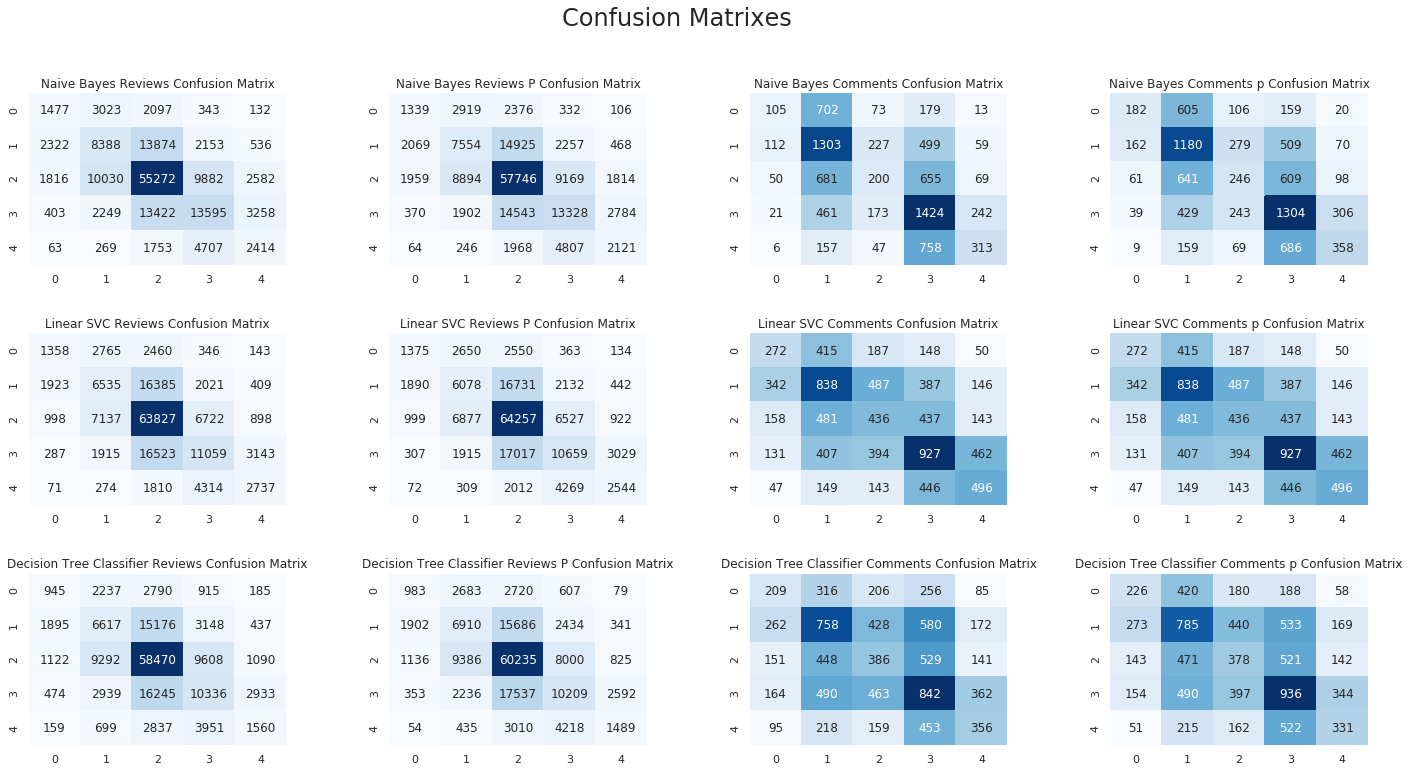

In [97]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,4,1)
plt.title("Naive Bayes Reviews Confusion Matrix")
sns.heatmap(confMatReviewsNB,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,2)
plt.title("Naive Bayes Reviews P Confusion Matrix")
sns.heatmap(confMatReviewsPNB,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,3)
plt.title("Naive Bayes Comments Confusion Matrix")
sns.heatmap(confMatCommentsNB,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,4)
plt.title("Naive Bayes Comments p Confusion Matrix")
sns.heatmap(confMatCommentsPNB,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,5)
plt.title("Linear SVC Reviews Confusion Matrix")
sns.heatmap(confMatReviewsSVC,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,6)
plt.title("Linear SVC Reviews P Confusion Matrix")
sns.heatmap(confMatReviewsPSVC,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,7)
plt.title("Linear SVC Comments Confusion Matrix")
sns.heatmap(confMatCommentsPSVC,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,8)
plt.title("Linear SVC Comments p Confusion Matrix")
sns.heatmap(confMatCommentsPSVC,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,9)
plt.title("Decision Tree Classifier Reviews Confusion Matrix")
sns.heatmap(confMatReviewsTree,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,10)
plt.title("Decision Tree Classifier Reviews P Confusion Matrix")
sns.heatmap(confMatReviewsPTree,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,11)
plt.title("Decision Tree Classifier Comments Confusion Matrix")
sns.heatmap(confMatCommentsTree,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(3,4,12)
plt.title("Decision Tree Classifier Comments p Confusion Matrix")
sns.heatmap(confMatCommentsPTree,annot=True,cmap="Blues",fmt="d",cbar=False)


plt.show()

# Conclusão


Ao analisar os três modelos sendo colocados em quatro situações diferentes, podemos observar alguns padrões. Os modelos que foram testados com as base de dados original obtiveram um accuracy mais elevado do que quando comparado com a base de dados somente com os comentários, dando a impressão que possuem mais chances de prever corretamente o sentimento em um comentário, porém ao analisar outras métricas como precison, recall e seu f1-score, podemos observar que esses modelos possuem grande taxas de acerto somente para identificar comentários neutros(2) e quanto aos outros sentimentos seu f1-score geralmente é menor que nos modelos testados com a outra base de dados, isto pode ser observado mais claramente ao analisar o heatmap de suas matrizes de confusão onde temos visivelmente uma concentração maior em previsões de sentimento neutro, enquanto nos outros modelos temos um heatmap mais disperso.

Também é possível observar que o processamento de texto não interferiu significavelmente na hora de treinamento do modelo chegando em alguns casos aumentar 1% de accuracy e em outros diminuir 1%, como no modelo de Naive Bayes e em outros somente de aumentar 2% como no modelo aplicando árvore de decisão.

Por fim, podemos concluir que nenhum dos modelos propostos apresenta uma solução ótima para o problema de identificação de sentimentos de granularidade fina em textos, sendo que o que apresentou o melhor resultado seria o de o de Naive Bayes com a base de dados possuindo somente os comentários originais e com o texto processado, o qual obteve um accuracy de cerca de 38% e um f1-score mais balanceado para cada um dos sentimentos.